# ECCOv4 FW Budget

Based on https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Salt_and_salinity_budget.html#Evaluating-the-freshwater-budget---Work-in-progress

Fresh water is defined as:

$fw = \frac{S_{ref} - S}{S_{ref}},$

where $S$ is salinity, $S_{ref}$ is a reference value.

We will evaluate each term in the freshwater budget:

$G^{fw}_\textrm{total} = G^{fw}_\textrm{advection} + G^{fw}_\textrm{diffusion} + G^{fw}_\textrm{forcing}$

We will calculate $G^{fw}_\textrm{diffusion}$ as the residual of the other terms. We will then compare with $G^{Sln}_\textrm{diffusion}$.

E Boland 2022 emmomp@bas.ac.uk

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import ecco_v4_py as ecco

In [2]:
# Reference salinity and density
Sref = 35.0
rhoconst = 1029

In [3]:
# Location of ECCO solution and grid
ECCO_dir='/data/expose/ECCOv4-r4/Version4/Release4'
ecco_grid=xr.open_dataset('~/data/orchestra/other_data/ECCO_r3_alt/ECCOv4r3_grid.nc') 

In [4]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC)

### Load Required Data Files from snapshots & monthly means

In [38]:
data_dir= ECCO_dir + '/nctiles_monthly_snapshots'

year_start = 1993
year_end = 1995

# Load one extra year worth of snapshots
ecco_monthly_snaps = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                         vars_to_load=['ETAN','SALT'],\
                         years_to_load=range(year_start, year_end+1))

num_months = len(ecco_monthly_snaps.time.values)
ecco_monthly_snaps = ecco_monthly_snaps.isel(time=np.arange(0, num_months-11))

num_months = len(ecco_monthly_snaps.time.values)

loading files of  ETAN
loading files of  SALT


In [124]:
data_dir= ECCO_dir + '/nctiles_monthly'

# Find the record of the last snapshot
## This is used to defined the exact period for monthly mean data
year_end = ecco_monthly_snaps.time.dt.year.values[-1]

ecco_monthly_mean = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                        vars_to_load=['SFLUX', 'oceSPtnd', 'ADVx_SLT', 'ADVy_SLT', 'ADVr_SLT',
                                      'DFxE_SLT', 'DFyE_SLT', 'DFrE_SLT', 'DFrI_SLT', 'oceFWflx',
                                      'UVELMASS', 'VVELMASS', 'WVELMASS', 'GM_PsiX', 'GM_PsiY',
                                      'ETAN', 'SALT'], years_to_load=range(year_start, year_end))


loading files of  ADVr_SLT
loading files of  ADVx_SLT
loading files of  ADVy_SLT
loading files of  DFrE_SLT
loading files of  DFrI_SLT
loading files of  DFxE_SLT
loading files of  DFyE_SLT
loading files of  ETAN
loading files of  GM_PsiX
loading files of  GM_PsiY
loading files of  SALT
loading files of  SFLUX
loading files of  UVELMASS
loading files of  VVELMASS
loading files of  WVELMASS
loading files of  oceFWflx
loading files of  oceSPtnd


In [125]:
# Scale factor (do we need, as for Salinity budget?)
rstarfac = ((ecco_grid.Depth + ecco_monthly_mean.ETAN)/ecco_grid.Depth)

In [126]:
grid = ecco.get_llc_grid(ds)
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)
# convert to seconds
delta_t = delta_t.astype('f4') / 1e9

In [127]:
ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)

In [128]:
ds = xr.merge([ecco_monthly_mean,
               ecco_monthly_snaps.rename({'time':'time_snp','ETAN':'ETAN_snp', 'SALT':'SALT_snp'})])

In [129]:
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

### Total freshwater tendency

In [130]:
f = (Sref - ecco_monthly_snaps.SALT)/Sref

G_total_Fw_month = f.diff('time')

In [131]:
G_total_Fw_month['time']=ecco_monthly_mean['time']

In [46]:
secs_per_month=365.25*60*60*24/12
# Freshwater tendency (m^3/s)
G_total_Fw = G_total_Fw_month*vol / secs_per_month

### Advective flux of freshwater

Advective fluxes of freshwater are calculated offline using salinity and velocity fields:

$\mathbf{\mathcal{F}_{adv}} = \iint_A\mathbf{u}_{res} \cdot \left(\frac{S_{ref} - S}{S_{ref}}\right)dA$

$u_{res}$ is the residual mean velocity field, which contains both the resolved (Eulerian), as well as the Gent-McWilliams bolus velocity (i.e., the parameterization of unresolved eddy effects).

In [49]:
UVELSTAR = grid.diff(ecco_monthly_mean.GM_PsiX, 'Z', boundary='fill')/ecco_grid.drF
VVELSTAR = grid.diff(ecco_monthly_mean.GM_PsiY, 'Z', boundary='fill')/ecco_grid.drF

In [50]:
GM_PsiXY_diff = grid.diff_2d_vector({'X' : ecco_monthly_mean.GM_PsiX*ecco_grid.dyG,
                                     'Y' : ecco_monthly_mean.GM_PsiY*ecco_grid.dxG}, boundary = 'fill')
WVELSTAR = (GM_PsiXY_diff['X'] + GM_PsiXY_diff['Y'])/ecco_grid.rA

In [51]:
SALT_at_u = grid.interp(ecco_monthly_mean.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(ecco_monthly_mean.SALT, 'Y', boundary='extend')
SALT_at_w = grid.interp(ecco_monthly_mean.SALT, 'Z', boundary='extend')

In [52]:
# Freshwater advective (Eulerian+Bolus) fluxes (m^3/s)
ADVx_FW = (ecco_monthly_mean.UVELMASS+UVELSTAR)*ecco_grid.dyG*ecco_grid.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (ecco_monthly_mean.VVELMASS+VVELSTAR)*ecco_grid.dxG*ecco_grid.drF*(Sref-SALT_at_v)/Sref
ADVr_FW = (ecco_monthly_mean.WVELMASS.where(ds.k_l>0).fillna(0.)+WVELSTAR)*ecco_grid.rA*(Sref-SALT_at_w)/Sref

In [53]:
ADVxy_diff = grid.diff_2d_vector({'X' : ADVx_FW, 'Y' : ADVy_FW}, boundary = 'fill')

# Convergence of horizontal advection (m^3/s)
adv_hConvFw = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

In [54]:
# Convergence of vertical advection (m^3/s)
adv_vConvFw = grid.diff(ADVr_FW, 'Z', boundary='fill')

In [150]:
# Sum horizontal and vertical convergences (m^3/s)
G_advection_Fw = adv_hConvFw/rstarfac + adv_vConvFw/rstarfac

### Freshwater & Salt Forcing

Use $ \frac{\partial fw}{\partial t} = -\frac{1}{S_{ref}}\frac{\partial S}{\partial t} $

so $G^{fw}_\textrm{forcing}= -\frac{1}{S_{ref}} G^{Sln}_\textrm{forcing}$

In [152]:
# Load SFLUX and add vertical coordinate
SFLUX = ds.SFLUX.assign_coords(k=0).expand_dims('k')

# Calculate forcing term by adding SFLUX and oceSPtnd (g/m^2/s)
forcS = xr.concat([SFLUX+ds.oceSPtnd,ds.oceSPtnd.isel(k=slice(1,None))], dim='k')

In [153]:
# Units of m psu/s
G_forcing_Slt = forcS/rhoconst

In [154]:
# Freshwater forcing (m^3/s)
forcFw = ecco_monthly_mean.oceFWflx/rhoconst*ecco_grid.rA

# Expand to fully 3d (using G_advection_Fw as template)
forcing_Fw = xr.concat([forcFw.reset_coords(drop=True).assign_coords(k=0).expand_dims('k'),
                          xr.zeros_like(G_advection_Fw).isel(k=slice(1,None))],
                         dim='k').where(ecco_grid.hFacC==1)

G_forcing_Fw = (forcing_Fw-G_forcing_Slt*ecco_grid.rA/Sref)/rstarfac

### Diffusive fw flux

In [155]:
# Convergence of freshwater diffusion (m^3/s)
G_diffusion_Fw = G_total_Fw - G_forcing_Fw - G_advection_Fw

### Diffusive salinity flux

In [156]:
DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_SLT, 'Y' : ds.DFyE_SLT}, boundary = 'fill')

# Convergence of horizontal diffusion (psu m^3/s)
dif_hConvS = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

In [157]:
# Load monthly averages of vertical diffusive fluxes
DFrE_SLT = ds.DFrE_SLT.transpose('time','tile','k_l','j','i')
DFrI_SLT = ds.DFrI_SLT.transpose('time','tile','k_l','j','i')

# Convergence of vertical diffusion (psu m^3/s)
dif_vConvS = grid.diff(DFrE_SLT, 'Z', boundary='fill') + grid.diff(DFrI_SLT, 'Z', boundary='fill')

In [158]:
# Sum horizontal and vertical convergences (psu m^3/s)
G_diffusion_Slt = (dif_hConvS + dif_vConvS)/rstarfac

### Plot budget terms

In [89]:
def plot_ecco(ecco_grid,dplot,cmap='RdBu_r',show_colorbar=True,**kwargs):
    [f,ax,p]=ecco.plot_proj_to_latlon_grid(ecco_grid.XC,ecco_grid.YC,dplot,show_colorbar=show_colorbar,
                                    cmap=cmap,**kwargs)[:3]
    return [f,ax,p]

-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


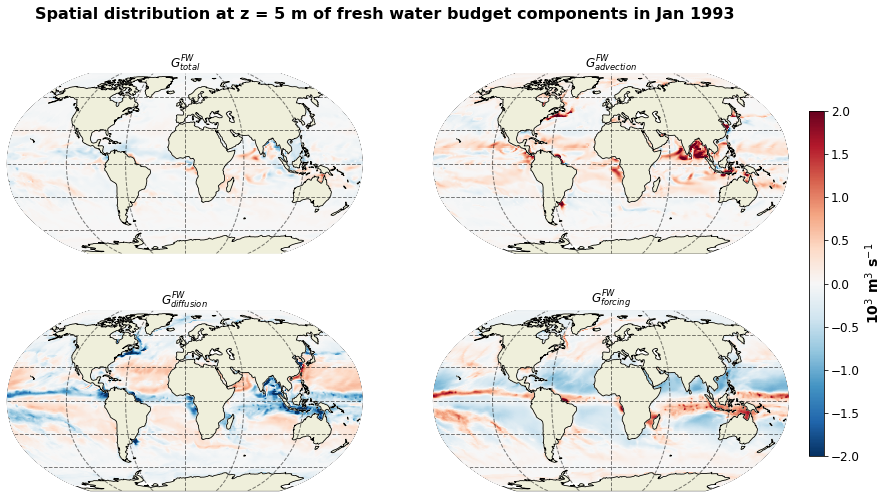

In [172]:
varlist=[G_total_Fw,G_advection_Fw,G_diffusion_Fw,G_forcing_Fw]
var_labs=['$G^{FW}_{total}$','$G^{FW}_{advection}$','$G^{FW}_{diffusion}$','$G^{FW}_{forcing}$']

t=0
k=0
fig = plt.figure(figsize=(14,8))
fig.suptitle('Spatial distribution at z = %i m of fresh water budget components in '\
             %np.round(-ecco_grid.Z[k].values)+str(ds.time[t].dt.strftime("%b %Y").values),
             fontsize=16, fontweight='bold')
for iv,var in enumerate(varlist):
    [f,ax,p]=plot_ecco(ecco_grid,var.isel(time=t,k=k)/1e3,subplot_grid=[2,2,iv+1],cmin=-2,cmax=2,show_colorbar=False)
    plt.title(var_labs[iv])

cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
cb = fig.colorbar(p,cax=cax, orientation='vertical',ticks=np.linspace(-2, 2, 9))
cb.ax.tick_params(labelsize=12)
cb.set_label('10$^{3}$ m$^3$ s$^{-1}$', fontsize=14, fontweight='bold')

/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


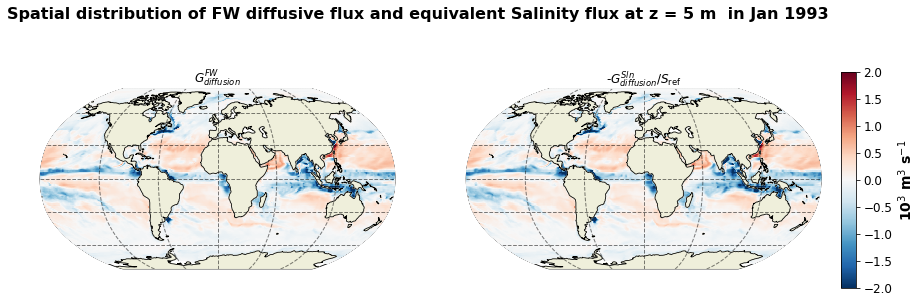

In [161]:
varlist=[G_diffusion_Fw,-G_diffusion_Slt/Sref]
var_labs=['$G^{FW}_{diffusion}$','-$G^{Sln}_{diffusion}$/$S_{\mathrm{ref}}$']

t=0
k=0
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spatial distribution of FW diffusive flux and equivalent Salinity flux at z = %i m  in '\
             %np.round(-ecco_grid.Z[k].values)+str(ds.time[t].dt.strftime("%b %Y").values),
             fontsize=16, fontweight='bold')
for iv,var in enumerate(varlist):
    [f,ax,p]=plot_ecco(ecco_grid,var.isel(time=t,k=k)/1e3,subplot_grid=[1,2,iv+1],cmin=-2,cmax=2,show_colorbar=False)
    plt.title(var_labs[iv])

cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
cb = fig.colorbar(p,cax=cax, orientation='vertical',ticks=np.linspace(-2, 2, 9))
cb.ax.tick_params(labelsize=12)
cb.set_label('10$^{3}$ m$^3$ s$^{-1}$', fontsize=14, fontweight='bold')

/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


Text(0.5, 1.0, 'FW diffusive flux - equivalent Salinity flux\n at z = 5 m in Jan 1993')

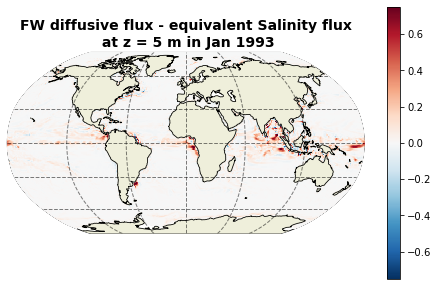

In [117]:
fig = plt.figure(figsize=(8,5))
[f,ax,p]=plot_ecco(ecco_grid,(varlist[0]-varlist[1]).isel(time=t,k=k)/1e3,cmin=-0.75,cmax=0.75,show_colorbar=True)
plt.title('FW diffusive flux - equivalent Salinity flux\n at z = {:1.0f} m in {}'.format(np.round(-ecco_grid.Z[k].values),ds.time[t].dt.strftime("%b %Y").values),fontsize=14, fontweight='bold')

### Time varying budget in the Sub-Polar North Atlantic

In [119]:
spna= (ecco_grid.XC>-60) & (ecco_grid.XC<0)& (ecco_grid.YC>45) & (ecco_grid.YC<65)

/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Freshwater budget terms in the Sub-Polar North Atlantic')

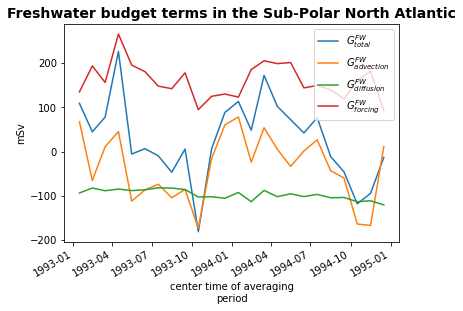

In [167]:
varlist=[G_total_Fw,G_advection_Fw,G_diffusion_Fw,G_forcing_Fw]
var_labs=['$G^{FW}_{total}$','$G^{FW}_{advection}$','$G^{FW}_{diffusion}$','$G^{FW}_{forcing}$']

for iv,var in enumerate(varlist):
    (var/1e3).where(spna).sum(dim=['i','j','k','tile']).plot(label=var_labs[iv])
plt.legend()
plt.ylabel('mSv')
plt.title('Freshwater budget terms in the Sub-Polar North Atlantic',fontsize=14, fontweight='bold')

/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/users/emmomp/conda-envs/ECCO_nb_env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Sub-Polar North Atlantic at z = 5 m in Jan 1993')

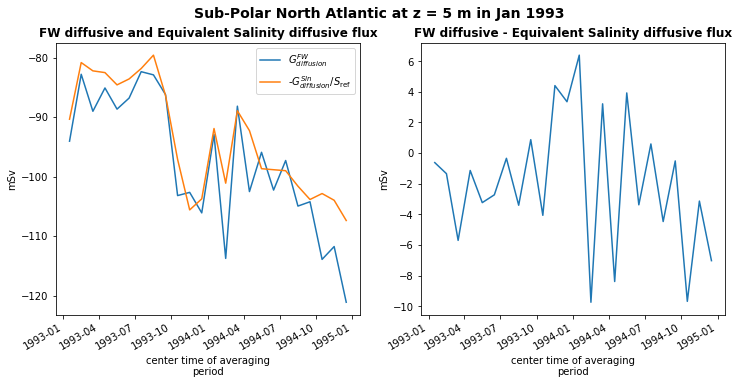

In [169]:
varlist=[G_diffusion_Fw,-G_diffusion_Slt/Sref]
var_labs=['$G^{FW}_{diffusion}$','-$G^{Sln}_{diffusion}$/$S_{\mathrm{ref}}$']

fig=plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for iv,var in enumerate(varlist):
    (var/1e3).where(spna).sum(dim=['i','j','k','tile']).plot(label=var_labs[iv])
plt.title('FW diffusive and Equivalent Salinity diffusive flux',fontweight='bold')  
plt.legend()
plt.ylabel('mSv')  
plt.subplot(1,2,2)
((varlist[0]-varlist[1])/1e3).where(spna).sum(dim=['i','j','k','tile']).plot()
plt.title('FW diffusive - Equivalent Salinity diffusive flux',fontweight='bold')
plt.ylabel('mSv')
plt.suptitle('Sub-Polar North Atlantic at z = {:1.0f} m in {}'.format(np.round(-ecco_grid.Z[k].values),ds.time[t].dt.strftime("%b %Y").values),fontsize=14, fontweight='bold')

676